In this notebook we coarse-grain MSM by assigning microstates to dunbrack states/noise, i.e., assign microstate centroid into a dunbrack state and group centroids together by what dunbrack state they fall into  

In [1]:
import sys, os
from pathlib import Path
from addict import Dict as Adict
import pandas as pd

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from MSMAnalysis import *
import mdtraj as md
from funcs_featurise import *
from funcs_db_assign import *
from funcs_indices import *
from funcs_plotting import *
from funcs_sample import *

In [2]:
protein = 'abl'
job_name = 'n_clusters'

base_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/')
data_path = base_path/f'data/{protein}/msm/{job_name}'
summary_f = data_path/f'{job_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

summary = raw.groupby('hp_id')[['t2', 'gap_2', 't3', 'gap_3']].agg(['mean', 'std'])
summary

t2                   gap_2                       t3  \
               mean           std      mean       std           mean   
hp_id                                                                  
0      1.897906e+06  2.256119e+06  7.204462  9.030466  325705.297247   
1      1.595177e+06  1.815086e+06  4.080848  5.590142  432235.379029   
2      2.136673e+06  3.122491e+06  4.077578  6.400808  535565.850037   
3      2.592150e+06  3.314022e+06  4.691758  5.925844  548228.747968   
4      2.344402e+06  3.034237e+06  4.193718  5.694533  575423.340252   
5      2.326571e+06  3.044765e+06  4.213856  5.890504  578997.424399   

                         gap_3            
                 std      mean       std  
hp_id                                     
0      387121.561458  2.595602  1.789663  
1      290889.808255  2.997026  4.150378  
2      326925.648340  3.210125  3.339652  
3      343147.326564  2.609170  1.852093  
4      413670.471434  2.750514  2.390593  
5      418920.923081  2.803241  2.576391

In [3]:
hp_id = 2
hp_dict = Adict(hps[hps.hp_id == hp_id].to_dict('records')[0])

# Set additional parameters for the MSM study 
hp_dict['markov__mode'] = 'ml'
hp_dict['count__mode'] = 'sliding'

In [4]:
all_features = ['dbdist', 'dbdihed', 'aloop', 'achelix', 'distgroup', 'dihedgroup']
features_for_msm = ['dbdist', 'dbdihed', 'aloop', 'achelix']

MA = MSMAnalysis(protein, trajlen_cutoff=1000)
MA.load_ftrajs(names=all_features, arc_dir=base_path/'data'/f'{protein}'/'ftrajs')

Loading feature:  dbdist


100%|██████████| 749/749 [00:04<00:00, 156.20it/s]


Loading feature:  dbdihed


100%|██████████| 749/749 [00:05<00:00, 130.62it/s]


Loading feature:  aloop


100%|██████████| 749/749 [00:50<00:00, 14.69it/s]


Loading feature:  achelix


100%|██████████| 749/749 [00:02<00:00, 286.48it/s]


Loading feature:  distgroup


100%|██████████| 749/749 [00:01<00:00, 480.66it/s]


Loading feature:  dihedgroup


100%|██████████| 749/749 [00:00<00:00, 1250.38it/s]

Features loaded: {'dbdist', 'aloop', 'achelix', 'dihedgroup', 'dbdihed', 'distgroup'}


In [5]:
study = MA.create_study(study_name=None,
                        hp_dict=hp_dict,    # hp_dict is ignored 
                        features=features_for_msm,
                        create_new=False,
                        wk_dir=base_path/f'data/{protein}/msm/validation/{job_name}_hp{hp_id}_effective_count')

Preparing feature trajectories...


100%|██████████| 749/749 [00:10<00:00, 68.46it/s] 


Restoring study: n_clusters_hp2_effective_count
Restoring TICA model


/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


Restoring Kmeans model


/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


Restoring transition count model
Restoring Bayesian MSM model
Models restore complete.


Determine the dominant dunbrack state of a microstate

In [25]:
def get_microstate_dunbrack_assignment(n_clusters, dtraj_cat, distgroup_cat, dihedgroup_cat):
    distgroup_asssignment = []
    dihedgroup_assignment = []

    for cluster_id in range(n_clusters):
        loc = np.where(dtraj_cat == cluster_id)

        distgroup = distgroup_cat[loc].flatten()
        distgroup_count = np.unique(distgroup, return_counts=True)
        distgroup_asssignment.append(distgroup_count[0][np.argmax(distgroup_count[1])])

        dihedgroup = dihedgroup_cat[loc].flatten()
        dihedgroup_count = np.unique(dihedgroup, return_counts=True)
        dihedgroup_assignment.append(dihedgroup_count[0][np.argmax(dihedgroup_count[1])])
    
    return np.array(distgroup_asssignment), np.array(dihedgroup_assignment)

In [9]:
distgroup, _ = prepare_ftrajs(MA.select_ftrajs(features=['distgroup']), convert_dihed=False)
distgroup_cat = np.concatenate(distgroup)
dihedgroup, _ = prepare_ftrajs(MA.select_ftrajs(features=['dihedgroup']), convert_dihed=False)
dihedgroup_cat = np.concatenate(dihedgroup)

Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 11257.76it/s]


Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 19542.61it/s]


In [26]:
ms_dist_assignment, ms_dihed_assignment = get_microstate_dunbrack_assignment(study._cluster__k, study.dtraj_cat, distgroup_cat, dihedgroup_cat)

Plot the microstates coloured with dunbrack dihedral group assignment.

In [68]:
study.msm_mod.stationary_distribution.sum()

1.0

/tmp/ipykernel_607145/1210022266.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(study.kmeans_centers[loc, 0], study.kmeans_centers[loc, 1], s=30, alpha=1, c=dihed_colours[assignment], edgecolor='black', linewidth=0.5, label=f'{dihed_cluster_labels[assignment]} ({population:.2f})')
/tmp/ipykernel_607145/1210022266.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(study.kmeans_centers[loc, 0], st

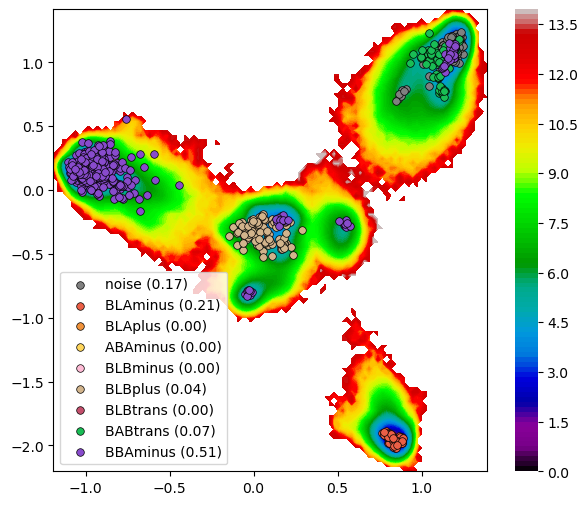

In [70]:
dihed_colours = np.array([(128/255, 128/255, 128/255),  # Gray
                        (235/255, 95/255, 70/255),    # Light Red
                        (240/255, 146/255, 58/255),   # Flamebright
                        (255/255, 214/255, 92/255),   # Light yellow
                        (255/255, 188/255, 214/255),  # Light pink
                        (210/255, 180/255, 140/255),  # Tan
                        (196/255, 79/255, 108/255),   # Strawberry
                        (25/255, 189/255, 85/255),    # Light Green
                        (136/255, 75/255, 204/255)])   # Light Purple
dihed_cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']


fig, ax = plt.subplots(figsize=(7, 6))
ax, contour, cbar = plot_energy2d(energy2d(study.ttraj_cat[:, 0], study.ttraj_cat[:, 1], weights=np.concatenate(study.traj_weights)), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))

for assignment in range(len(dihed_colours)):
    loc = np.where(ms_dihed_assignment == assignment-1)
    population = np.sum(study.msm_mod.stationary_distribution[loc])
    ax.scatter(study.kmeans_centers[loc, 0], study.kmeans_centers[loc, 1], s=30, alpha=1, c=dihed_colours[assignment], edgecolor='black', linewidth=0.5, label=f'{dihed_cluster_labels[assignment]} ({population:.2f})')
    
legend = ax.legend(loc='lower left', fontsize=10)
plt.show()

/tmp/ipykernel_607145/2105578171.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(study.kmeans_centers[loc, 0], study.kmeans_centers[loc, 1], s=30, alpha=1, c=dist_colors[assignment], edgecolor='black', linewidth=0.5, label=f'{spatial_cluster_labels[assignment]} ({population:.2f})')
/tmp/ipykernel_607145/2105578171.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(study.kmeans_centers[loc, 0], st

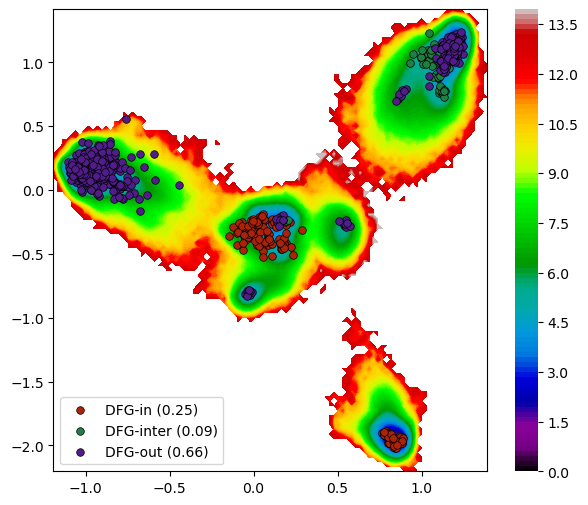

In [69]:
dist_colors = np.array([
(173/255, 35/255, 10/255),   # Red
(28/225, 128/255, 65/255),   # Green
(80/255, 29/255, 138/255)])  # Purple
spatial_cluster_labels = ['DFG-in', 'DFG-inter', 'DFG-out']

fig, ax = plt.subplots(figsize=(7, 6))
ax, contour, cbar = plot_energy2d(energy2d(study.ttraj_cat[:, 0], study.ttraj_cat[:, 1], weights=np.concatenate(study.traj_weights)), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))
for assignment in range(len(dist_colors)):
    loc = np.where(ms_dist_assignment == assignment)
    population = np.sum(study.msm_mod.stationary_distribution[loc])

    ax.scatter(study.kmeans_centers[loc, 0], study.kmeans_centers[loc, 1], s=30, alpha=1, c=dist_colors[assignment], edgecolor='black', linewidth=0.5, label=f'{spatial_cluster_labels[assignment]} ({population:.2f})')

legend = ax.legend(loc='lower left', fontsize=10)
plt.show()